In [1]:
import pandas as pd
import rstoolbox as rs

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'

rs.utils.format_Ipython()

## Load Data

In [2]:
def load_data():
    alpha = rs.io.parse_rosetta_file('docking/amyloid_alpha/alpha_dock.minisilent.gz',
                                     {'scores_by_residue': ['residue_ddg_']})
    alpha = rs.utils.add_column(alpha, 'experiment', 'alpha')
    beta  = rs.io.parse_rosetta_file('docking/amyloid_beta/beta_dock.minisilent.gz',
                                     {'scores_by_residue': ['residue_ddg_']})
    beta  = rs.utils.add_column(beta, 'experiment', 'beta')
    
    lid   = rs.io.parse_rosetta_file('docking/albumin_cterm_lid/lid_dock.minisilent.gz',
                                     {'scores_by_residue': ['residue_ddg_']})
    lid   = rs.utils.add_column(lid, 'experiment', 'lid')
    return pd.concat([alpha, beta, lid], ignore_index=True)
    
df = load_data()

## Distributions

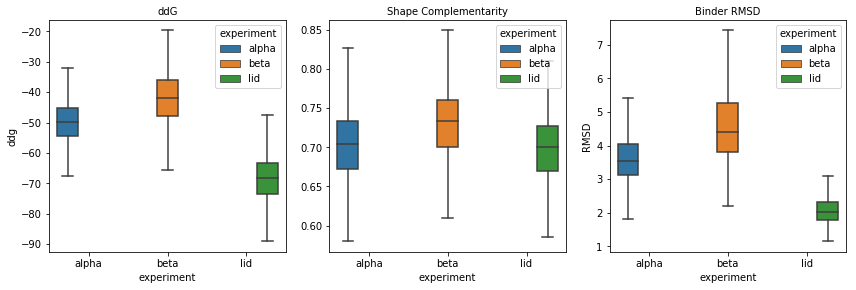

In [3]:
fig = plt.figure(figsize=(12, 4))

ax00 = plt.subplot2grid((1, 3), (0, 0))
ax01 = plt.subplot2grid((1, 3), (0, 1))
ax02 = plt.subplot2grid((1, 3), (0, 2))


_ = sns.boxplot( 'experiment', 'ddg',   'experiment', data=df, ax=ax00, showfliers=False )
rs.utils.add_top_title(ax00, 'ddG')
_ = sns.boxplot( 'experiment', 'shape', 'experiment', data=df, ax=ax01, showfliers=False )
rs.utils.add_top_title(ax01, 'Shape Complementarity')
ax01.set_ylabel('')
_ = sns.boxplot( 'experiment', 'RMSDB', 'experiment', data=df, ax=ax02, showfliers=False )
rs.utils.add_top_title(ax02, 'Binder RMSD')
ax02.set_ylabel('RMSD')


plt.tight_layout()
plt.savefig('images/distributions.svg')
plt.show()


## Select Top 200
A silent file with this top 200 will be added to the repo

In [4]:
top_alpha = df[(df['experiment'] == 'alpha')].sort_values(['ddg', 'shape']).head(200)
with open('docking/amyloid_alpha/top200.list', 'w') as fd:
    fd.write('\n'.join(top_alpha['description']))
top_beta  = df[(df['experiment'] == 'beta')].sort_values(['ddg', 'shape']).head(200)
with open('docking/amyloid_beta/top200.list', 'w') as fd:
    fd.write('\n'.join(top_beta['description']))

## Name Top 5 for Image

In [5]:
print(top_alpha.sort_values('ddg')[['description', 'ddg', 'shape']].head(5).values)
print(top_beta.sort_values('ddg')[['description', 'ddg', 'shape']].head(5).values)

[[u'alpha124_0006' -78.275 0.632]
 [u'alpha385_0010' -75.73 0.716]
 [u'alpha53_0005' -75.002 0.748]
 [u'alpha635_0009' -74.754 0.762]
 [u'alpha609_0006' -74.049 0.718]]
[[u'beta122_0001' -79.491 0.728]
 [u'beta568_0006' -75.181 0.702]
 [u'beta93_0001' -75.082 0.665]
 [u'beta166_0003' -74.597 0.736]
 [u'beta341_0010' -74.359 0.774]]


## Key Residues in Albumina C-terminal

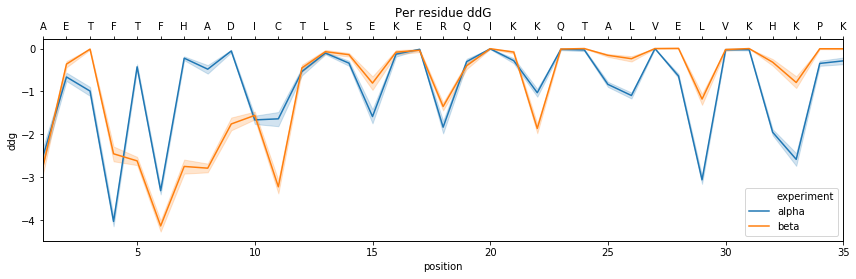

In [14]:
def expand_per_res(row):
    data = []
    for i, x in enumerate(row['residue_ddg_'][:35]):
        data.append([i+1, x])
    return pd.DataFrame({'ddg': row['residue_ddg_'][:35], 'position': list(range(1, 36))})

ddg_alpha = pd.concat(list(top_alpha.apply(lambda row: expand_per_res(row), axis=1)))
ddg_alpha = rs.utils.add_column(ddg_alpha, 'experiment', 'alpha')
ddg_beta  = pd.concat(list(top_beta.apply(lambda row: expand_per_res(row), axis=1)))
ddg_beta  = rs.utils.add_column(ddg_beta, 'experiment', 'beta')
ddgs = pd.concat([ddg_alpha, ddg_beta])
fig = plt.figure(figsize=(12, 4))
ax00 = plt.subplot2grid((1, 1), (0, 0))
_ = sns.lineplot(x="position", y="ddg", hue='experiment', data=ddgs, ax=ax00)
ax00.set_xlim(1, 35)
ax00top = ax00.twiny()
ax00top.set_xticks(range(0, 35))
ax00top.set_xticklabels(list('AETFTFHADICTLSEKERQIKKQTALVELVKHKPK'))
plt.title('Per residue ddG', y=1.08)
plt.tight_layout()
plt.savefig('images/residue_ddg.svg')
plt.show()